In [1]:
import os
import sys
sys.path.append('../../kl_tools/')
import numpy as np
from astropy.units import Unit
import matplotlib.pyplot as plt
import galsim
import galsim.roman as roman

import basis
import cube
import intensity
import likelihood
import mcmc
import parameters
import priors
import utils
import velocity
from spectrum import Spectrum
from MockObs import Mock
%matplotlib inline

# Developing Mock Single Object Observations

## Motivation
This module is designed to generate mock observations (e.g. grism or photometry) for single galaxy. In MCMC sampling, this module plays an essential role by generating model "vector" and pipe it through the likelihood function.

Some realisms should be considered are

- [x] shear, galaxy geometric configuration and velocity modelling
- [x] sky background or zodiac light
- [x] system bandpass
- [x] spectral resolution and grism dispersion
- [ ] bandpass-dependent PSF
- [x] exposure time
- [x] collecting area
- [x] pixelization
- [x] noise: Poisson noise, Read noise and dark current
- [ ] TFR: implement as a TFR model rather than a Gaussian prior

The mock observation is build on top of `spectrum.py`, `intensity.py`, `velocity.py`, `parameters.py` etc.

## Arguments

An Mock object is constructed by passing two dictionary argument, `theta_pars` and `pars`, which contains the following `keywords`:`defalut_values`,`explanations`

1. `theta_pars`: dictionary of MCMC-sampled parameters
    - `g1`:`0.0`, shear
    - `g2`:`0.0`, shear 
    - `theta_int`: `0.`, intrinsic position angle of the source galaxy, in `radians`
    - `sini`:`0.2`, the sin value of inclination angle
    - `v0`:`0`, the systematic velocity of the source galaxy. Since we have redshift `z` fixed in `SED` dict, this one is dealing with the redshift residuals when including kinematics and shear modeling.
    - `vcirc`:`200`, the maximum circular rotation velocity of galaxy disk.
    - `rscale`:`0.5`, the scale radius of the galaxy rotation curve model.
2. `pars`: dictionary of fixed parameters during MCMC sampling
    - `priors`: dictionary of priors for sampled parameters in `theta_pars`
        - `g1`: `priors.GaussPrior(0., 0.1)`
        - `g2`: `priors.GaussPrior(0., 0.1)`
        - `theta_int`: `priors.UniformPrior(-np.pi/2., np.pi/2.)`
        - `sini`: `priors.UniformPrior(0., 1.)`
        - `v0`: `priors.GaussPrior(0, 20)`
        - `vcirc`: `priors.GaussPrior(200, 10)`, prior on circular velocity, currently working as a dirty way to implement Tully-Fisher relation.
        - `rscale`: `priors.UniformPrior(0, 10)`
    - `meta`: dictionary of meta parameters for building `ModelCube` object
        - `Nx`:`64`, number of pixels along x-axis
        - `Ny`:`64`, number of pixels along y-axis
        - `scale`:`0.1`, pixel scale in `arcsec`. Note that this is different from the real pixel scale in observations, since different observations from different instruments can have different pixel scales. This parameter should be set to a value smaller than the real pixel scales in the observations.  
        - `lambda_range`:`[1200, 1400]`, the bule and red limit of the observer-frame wavelength $\lambda$ when building model cube. In units of `nm`
        - `lambda_res`: `1`, the wavelength resolution of model cube wavelength grid, in `nm`
    - `intensity`: dictionary of intensity profile, for building `IntensityMap` object
        - `type`:`inclined_exp`, type of intensity profile, can be `inclined_exp`/`basis`/`default`
        - `hlr`:`0.5`, half-light-radius in `arcsec`
    - `velocity`: dictionary of velocity map, for building `VelocityMap` object
        - `v_unit`:`Unit('km / s')`, the unit of `vcirc` and `v0`
        - `r_unit`:`Unit('arcsec')`, the unit of `rscale`
    - `SED`: dictionary of SED, for building `Spectrum` object
        - `template`:`../../data/Simulation/GSB2.spec`, the galaxy rest-frame template file used for building rest-frame continuum of the galaxy. The template file contains two columns, `wavelength` and `flux`
        - `wave_type`: `Ang`, unit of the `wavelength` column in `template`, can be `ang`/`nm`
        - `flux_type`: `flambda`, type of the `flux` column in `template`, can be `flambda`/`fnu`/`dimensionless` 
        - `z`: `1.0`, redshift of the galaxy
        - `wave_range`: `(500, 3000)`, the observer-frame wavelength range for building `Spectrum`, in units of `nm`
        - `obs_cont_norm`: `(1400, 1e-17)`, normalization of the continuum $(\lambda_{\mathrm{obs}}, f_\lambda(\lambda_{\mathrm{obs}}))$. $\lambda$ in units of `nm`, $f_\lambda(\lambda)$ in units of `erg/s/cm2/nm`
        - `lines`: `{'Halpha': 1e-15, 'OII':[1e-15, 1.2e-15], 'OIII':[1e-15, 1.2e-15]}`, a dictionary {`keys`:`vals`} of emission line fluxes, with `keys` the line species (`Halpha`/`OII`/`OIII`) and `vals` the observer-frame flux in units of `erg/s/cm2`
        - `line_sigma_int`: `{'Halpha': 4, 'OII':[2,2], 'OIII':[3,3]}`, the intrinsic emission line with (FWHM), in units of `nm`
    - `observations`: a list of dictionaries of observations. Since different types of observations require different parameters, the dictionary is highly module-dependent. However, some common keywords includes `type` indicating the observation type (e.g. `grism`/`photometry`), and `inst_name` indicating the instrument name. The default value contains three dictionaries, standing for two grism observations and one photometry observation. The default value, for example, is
        - observation 1: _Roman_ WFI/GRISM observation along roll angle 1
            - `inst_name`: `Roman/WFI`, instrument name
            - `type`: `grism`, observation type
            - `bandpass`: `../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat`, bandpass file name to build `Bandpass` object, contains two columns `wavelength` and `throughput`
            - `Nx`: `32`, number of pixels along x-axis
            - `Ny`: `32`, number of pixels along y-axis
            - `pixel_scale`: `0.11`, instrument pixel scale in `arcsec`
            - `R_spec`: `461`, spectral resolution at 1 `micron`. May replace this parameter with dispersion file name to build a `LookUpTable` for calculating dispersion replacement.
            - `offset`: `-1210.22`, offset in `pixel numbers`
            - `psf_type`: `airy`, PSF type, can be  `none`/`airy`/`moffat`. `kolmogorov`/`vonkarman`/`opticalpsf` to be implemented.
            - `psf_kwargs`: `{'fwhm':0.13}`, kwargs needed to build `PSF` model. Note that in case of `Airy` PSF, we do not need any extra arguments here.
            - `disp_ang`: `0.`, direction of dispersion, in units of `radians`
            - `diameter`: `240`, diameter of the aperture stop, in units of `cm`
            - `exp_time`: `30.`, exposure time, in units of `second`
            - `gain`: `1.`, detector gain, in units of `electrons / ADU`
        - observation 2: _Roman_ WFI/GRISM observation along roll angle 2
            - `inst_name`: `Roman/WFI`
            - `type`: `grism`
            - `bandpass`: `../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat`
            - `Nx`: `64`
            - `Ny`: `64`
            - `pixel_scale`: `0.11`
            - `R_spec`:`461`
            - `offset`:`-1210.22`
            - `psf_type`: `airy`
            - `psf_kwargs`: `{'fwhm':0.13}`
            - `disp_ang`: `np.pi/2.`
            - `diameter`: `240`
            - `exp_time`: `30.`
            - `gain`: `1.`
        - observation 3: _Roman_ WFI/Photometry image observation in H band
            - `inst_name`: `Roman/WFI`
            - `type`: `photometry`
            - `bandpass`: `../../data/Bandpass/Roman/WFI_F129.dat`
            - `Nx`: `32`
            - `Ny`: `32`
            - `pixel_scale`: `0.11`
            - `psf_type`: `airy`
            - `psf_kwargs`: `{'fwhm':0.13}`
            - `diameter`: `240`
            - `exp_time`: `30.`
            - `gain`: `1.`
    - `use_numba`: False, flag for whether use `numba` in calculation. Currently still under testing


## Attributes and Methods

An `Mock` object has the following attributes:

- `self.theta_pars`: save the sampled parameters dictionary
- `self.pars`: save the fixed parameters dictionary
- `self.V_im`: LoS velocity map in units of `km / s`
- `self.imap_img`: intensity profile
- `self.imap`: `IntensityMap` object
- `self.vmap`: `VelocityMap` object
- `self.SED`: `Spectrum` object
- `self.modelcube`: `ModelCube` object, storing the sheared and Doppler-shifted spatial-wavelength distribution
- `self.modelcube_wave`: wavelength grid

An `Mock` object has the following methods:

- `__init__(theta_pars, pars)`: initializing the `Mock` object with parameter dicts `theta_pars` and `pars`
- `updatePars(theta_pars, pars)`: update parameters by passing new params dicts `theta_pars` and `pars`
- `getModelCube()`: calculate `ModelCube` object after setting parameters
- `getExposure(noise_free=False)`: calculate observation data given `observations` in `pars`

internal methods:
- `_setup_vmap(model_name='default')`
- `_setup_imap(datacube)`
- `_setup_SED(rel_err=-1)`
- `_getGrismExposure(pars, noise_free=True)`
- `_geGrismDispersed(modelslice, lambdas, wave_edge, bandpass, pars)`
- `_get_dispersion(lam, pars)`
- `_build_PSF_model(pars, **kwargs)`
- `_getPhotometryExposure(pars, noise_free=True)`


In [10]:
theta_pars = {'g1':0.0, 'g2':0.0, 'theta_int': 0., 'sini':0.5,'v0':0,'vcirc':200,'rscale':0.5}
pars = {
    'priors':{
        'g1': priors.GaussPrior(0., 0.1),
        'g2': priors.GaussPrior(0., 0.1),
        'theta_int': priors.UniformPrior(-np.pi/2., np.pi/2.),
        'sini': priors.UniformPrior(0., 1.),
        'v0': priors.GaussPrior(0, 20),
        'vcirc': priors.GaussPrior(200, 10),
        'rscale': priors.UniformPrior(0, 10),
    },
    'meta':{
        'Nx':64,
        'Ny':64,
        'scale':0.1,# arcsec
        'lambda_range':[1200, 1400],
        'lambda_res': 1,# nm
    },
    'intensity':{
        'type':'inclined_exp',
        'hlr':0.5,# arcsec
    },
    'velocity':{
        'v_unit':Unit('km / s'),
        'r_unit':Unit('arcsec'),
    },
    'SED':{
        'template':'../../data/Simulation/GSB2.spec',
        'wave_type': 'Ang',
        'flux_type': 'flambda',
        'z': 1.0,
        'wave_range': (500, 3000), # nm
        # obs-frame continuum normalization (nm, erg/s/cm2/nm)
        'obs_cont_norm': (1400, 1e-17),
        # a dict of line names and obs-frame flux values (erg/s/cm2)
        'lines': {'Halpha': 1e-15, 'OII':[1e-15, 1.2e-15], 'OIII':[1e-15, 1.2e-15]},
        # intrinsic linewidth in nm
        'line_sigma_int': {'Halpha': 4, 'OII':[2,2], 'OIII':[3,3]},
    },
    # observation related parameters
    # Note that from the same galaxy and shear model, we can derive 
    # multiple types of data,
    # e.g. `photometry`, `slit_spectroscopy`, `grism` and/or `IFU`.
    # Thus 'observations' is a list of dictionaries that specify 
    # observation-wise parameters.
    # TODO: maybe think about more flexible way to describe dispersion
    'observations':[

        # Roman WFI/GRISM observation, roll angle 1
        {'inst_name':'Roman/WFI',
         'type':'grism',
         'bandpass':'../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat',
         'Nx': 64,# number of pixels
         'Ny': 64,
         'pixel_scale': 0.11,# arcsec
         'R_spec':461,# at 1 micron
         'offset':-1210.22,# pix
         # can be 'none'/'airy'/'moffat'
         # 'kolmogorov'/'vonkarman'/'opticalpsf' to be implemented.
         'psf_type':'airy',
         # pass the needed params to build PSF model here
         # in case of airy, we don't need any params
         'psf_kwargs':{'fwhm':0.13},# arcsec
         'disp_ang':0.,# radian
         'diameter':240,# cm
         'exp_time':600.,# seconds
         'gain':1.,
         'noise':{'type':'ccd','sky_level':0.65*1.2,'read_noise':8.5},
         },
        # Roman WFI/GRISM observation, roll angle 2
        {'inst_name':'Roman/WFI',
         'type':'grism',
         'bandpass':'../../data/Bandpass/Roman/WFI_Grism_1stOrder.dat',
         'Nx': 64,# number of pixels
         'Ny': 64,
         'pixel_scale': 0.11,# arcsec
         'R_spec':461,# at 1 micron
         'offset':-1210.22,
         'psf_type':'airy',
         'psf_kwargs':{'fwhm':0.13},# arcsec
         'disp_ang':np.pi/2.,# radian
         'diameter':240,# cm
         'exp_time':600.,# seconds
         'gain':1.,
         'noise':{'type':'ccd','sky_level':0.65*1.2,'read_noise':8.5},
         },
        # Roman WFI/Photometry image observation, H band
        {'inst_name':'Roman/WFI',
         'type':'photometry',
         'bandpass':'../../data/Bandpass/Roman/WFI_F129.dat',
         'Nx': 32,# number of pixels
         'Ny': 32,
         'pixel_scale': 0.11,# arcsec
         'psf_type':'airy',
         'psf_kwargs':{'fwhm':0.13},# arcsec
         'diameter':240,# cm
         'exp_time':600.,# seconds
         'gain':1.,
         'noise':{'type':'ccd','sky_level':0.65*1.2,'read_noise':8.5},
         },
    ],
    'use_numba': False,
}

In [28]:
def log_prior(theta, pars):
    theta_pars = {}
    theta_pars_keys = ['g1', 'g2', 'theta_int', 'sini', 'v0', 'vcirc', 'rscale']
    for i,key in enumerate(theta_pars_keys):
        theta_pars[key] = theta[i]
    logprior = 0
    for i in theta_pars.keys():
        pobj = pars['priors'][i]
        logprior += pobj(theta_pars[i], log=True)
    return logprior

def log_likelihood(theta, pars, dvs, covmats):
    
    theta_pars = {}
    theta_pars_keys = ['g1', 'g2', 'theta_int', 'sini', 'v0', 'vcirc', 'rscale']
    for i,key in enumerate(theta_pars_keys):
        theta_pars[key] = theta[i]
    m = Mock(theta_pars, pars)
    obs_data, covmats = m.getExposure()
    # calculate chi2
    diff = [dv.array-mv.array for dv,mv in zip(dvs, obs_data)]
    chi2 = 0
    dof = 0
    for _diff, cov in zip(diff, covmats):
        noise_average = np.std(cov.array)
        chi2 += np.sum( (_diff/noise_average)**2 )
        dof += _diff.flatten().shape[0]
    return -0.5*chi2 + log_prior(theta, pars)

In [11]:
### To get simulated data, run
### m = Mock(theta_pars, pars)
### obs_data, covmats = m.getExposure()
m = Mock(theta_pars, pars)

## ModelCube Info

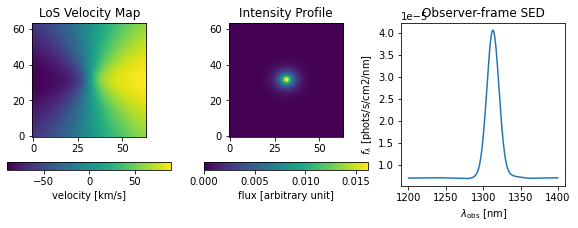

In [12]:
fig, axes = plt.subplots(1,3,figsize=(10,3))

cb1 = axes[0].imshow(m.V_img, origin='lower')
plt.colorbar(cb1, ax=axes[0], orientation='horizontal', label='velocity [km/s]')
axes[0].set_title('LoS Velocity Map')

cb2 = axes[1].imshow(m.imap_img, origin='lower')
plt.colorbar(cb2, ax=axes[1], orientation='horizontal', label='flux [arbitrary unit]')
axes[1].set_title('Intensity Profile')

axes[2].plot(m.modelcube_wave, m.SED.spectrum(m.modelcube_wave))
axes[2].set(xscale='linear', yscale='linear',
            xlabel=r'$\lambda_\mathrm{obs}$ [nm]', ylabel=r'$f_\lambda$ [phots/s/cm2/nm]')
axes[2].set_title('Observer-frame SED')

plt.show()

In [13]:
# calculate observation data
%time obs_data, covmats = m.getExposure()

CPU times: user 958 ms, sys: 25.2 ms, total: 984 ms
Wall time: 989 ms


## Observation Data

### Non-sheared

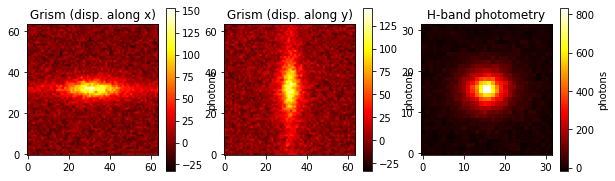

In [14]:
fig, axes = plt.subplots(1,3, figsize=(10,3))
cmap = 'hot'
cb1 = axes[0].imshow(obs_data[0].array, origin='lower', cmap=cmap)
axes[0].set_title("Grism (disp. along x)")
plt.colorbar(cb1, ax=axes[0], label='photons')

cb2 = axes[1].imshow(obs_data[1].array, origin='lower', cmap=cmap)
axes[1].set_title("Grism (disp. along y)")
plt.colorbar(cb2, ax=axes[1], label='photons')

cb3 = axes[2].imshow(obs_data[2].array, origin='lower', cmap=cmap)
axes[2].set_title("H-band photometry")
plt.colorbar(cb3, ax=axes[2], label='photons')

plt.show()

###  Sheared

In [15]:
theta_pars_sheared = theta_pars.copy()
pars_sheared = pars.copy()
theta_pars_sheared['g1']=0.05
theta_pars_sheared['g2']=0.05
%time m_sheared = Mock(theta_pars_sheared, pars_sheared)
%time obs_data_sheared, covmats = m_sheared.getExposure()

CPU times: user 118 ms, sys: 58.7 ms, total: 177 ms
Wall time: 176 ms
CPU times: user 941 ms, sys: 10.1 ms, total: 951 ms
Wall time: 951 ms


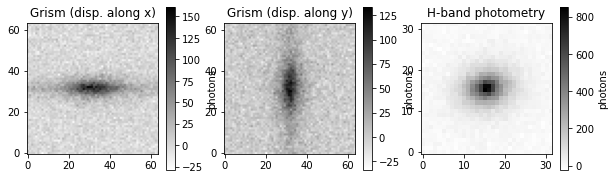

In [16]:
fig, axes = plt.subplots(1,3, figsize=(10,3))
cmap = 'binary'
cb1 = axes[0].imshow(obs_data_sheared[0].array, origin='lower', cmap=cmap)
axes[0].set_title("Grism (disp. along x)")
plt.colorbar(cb1, ax=axes[0], label='photons')

cb2 = axes[1].imshow(obs_data_sheared[1].array, origin='lower', cmap=cmap)
axes[1].set_title("Grism (disp. along y)")
plt.colorbar(cb2, ax=axes[1], label='photons')

cb3 = axes[2].imshow(obs_data_sheared[2].array, origin='lower', cmap=cmap)
axes[2].set_title("H-band photometry")
plt.colorbar(cb3, ax=axes[2], label='photons')

plt.show()

### Sheared - Non-sheared

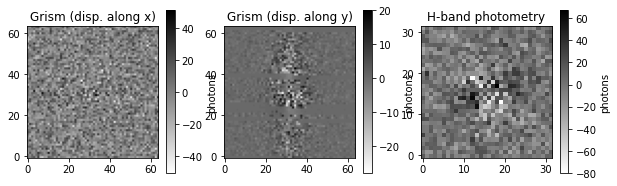

In [17]:
fig, axes = plt.subplots(1,3, figsize=(10,3))
cmap = 'binary'

diff = [
    obs_data_sheared[0].array-obs_data[0].array,
    obs_data_sheared[1].array-obs_data[1].array,
    obs_data_sheared[2].array-obs_data[2].array,
]

cb1 = axes[0].imshow(diff[0], origin='lower', cmap=cmap)
axes[0].set_title("Grism (disp. along x)")
plt.colorbar(cb1, ax=axes[0], label='photons')

cb2 = axes[1].imshow(diff[1], origin='lower', cmap=cmap)
axes[1].set_title("Grism (disp. along y)")
plt.colorbar(cb2, ax=axes[1], label='photons')

cb3 = axes[2].imshow(diff[2], origin='lower', cmap=cmap)
axes[2].set_title("H-band photometry")
plt.colorbar(cb3, ax=axes[2], label='photons')

plt.show()

In [21]:
# chi2 difference
chi2 = 0
dof = 0
for _diff, cov in zip(diff, covmats):
    noise_average = np.std(cov.array)
    chi2 += np.sum( (_diff.T/noise_average)**2 )
    dof += _diff.flatten().shape[0]
print("delta chi2 = {0:.2f} ({1:.2f} per d.o.f.)".format(chi2,
                                                         chi2/dof))

delta chi2 = 12270.76 (1.33 per d.o.f.)


## Try MCMC

In [30]:
theta_pars = {'g1':0.0, 'g2':0.0, 'theta_int': 0., 'sini':0.5,'v0':0,'vcirc':200,'rscale':0.5}
theta_test = [0., 0., 0., 0.5, 0., 200., 0.5]
loglike = log_likelihood(theta_test, pars, obs_data, covmats)
logprior = log_prior(theta_test, pars)
print(loglike, logprior)

-7.816216292222082 -7.816216292222082


In [ ]:
import emcee
from numpy.random import default_rng
import os, time
os.environ["OMP_NUM_THREADS"] = "1"

balls = [0.1, 0.1, 0.1, 0.05, 5, 10, 0.05, ]

ndim, nwalkers = 7, 100
p0 = np.zeros((nwalkers, ndim))
for i in range(nwalkers):
    for j in range(ndim):
        p0[i,j] = theta_test[j] + np.random.normal(0.0, balls[j])
print("start sampling")
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[pars, obs_data, covmats])
state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()
start = time.time()
sampler.run_mcmc(state, 10000, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))

9.035159


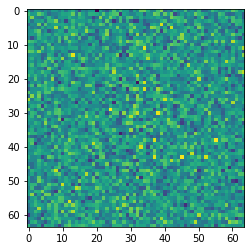

In [19]:
plt.imshow(covmats[2].array)
noise_average = np.std(covmats[2].array)
print(noise_average)

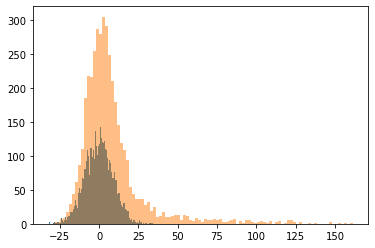

In [20]:
plt.hist(covmats[0].array.flatten(), bins=100)
plt.hist((obs_data_sheared[0]).array.flatten(), bins=100, alpha=0.5)
plt.show()

### Random Scratch Below...

In [ ]:
# check for asymmetrical feature in model cube 
asymmetric_data_x = m.modelcube._data.copy()
asymmetric_data_y = m.modelcube._data.copy()
for i in range(m.modelcube.shape[1]):
    asymmetric_data_x[:,:,i] -= m.modelcube._data[:,:,m.modelcube.shape[1]-1-i]
    asymmetric_data_y[:,i,:] -= m.modelcube._data[:,m.modelcube.shape[1]-1-i,:]

fig, axes = plt.subplots(1,2,figsize=(8,3))

cb1 = axes[0].imshow(np.sum(asymmetric_data_x, axis=0), origin='lower')
axes[0].set_title('x-flip')
axes[0].set(xlabel='X', ylabel='Y')
plt.colorbar(cb1, ax=axes[0], label='photons/s/cm2/nm', orientation='vertical')

cb2 = axes[1].imshow(np.sum(asymmetric_data_y, axis=0), origin='lower')
axes[1].set_title('y-flip')
axes[1].set(xlabel='X', )
plt.colorbar(cb2, ax=axes[1], label='photons/s/cm2/nm', orientation='vertical')

plt.show()

In [ ]:
roman_bandpasses = galsim.roman.getBandpasses()
print(roman_bandpasses.keys())
roman.getSkyLevel(roman_bandpasses['W149'], exptime=60)*0.11*0.11

In [ ]:
roman.read_noise

In [ ]:
rng = galsim.BaseDeviate(1234567+1)
noise = galsim.CCDNoise(rng, read_noise = roman.read_noise, sky_level=0.65*1.2)

In [ ]:
img_noise = obs_data_sheared[0][2].copy()
img_noise.addNoise(noise)
noise_img = img_noise - obs_data_sheared[0][2]
fig, axes = plt.subplots(1,3, figsize=(11,3))

axes[0].imshow(img_noise.array, origin='lower')
axes[1].imshow(obs_data_sheared[0][2].array, origin='lower')
axes[2].imshow(noise_img.array, origin='lower')

In [ ]:
noise_img.array